# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret as spr

Load the interferometric data

In [2]:
CP = np.load('C:/Users/saucourt/Coding/Speckle-Retrieval/notebooks/NF__shaping_frames_20250612-153737.npz')['frames']
CL = np.load('C:/Users/saucourt/Coding/Speckle-Retrieval/notebooks/FF__shaping_frames_20250612-153737.npz')['frames']

print(CP.shape)
print(CL.shape)

(1, 384, 384)
(1, 384, 384)


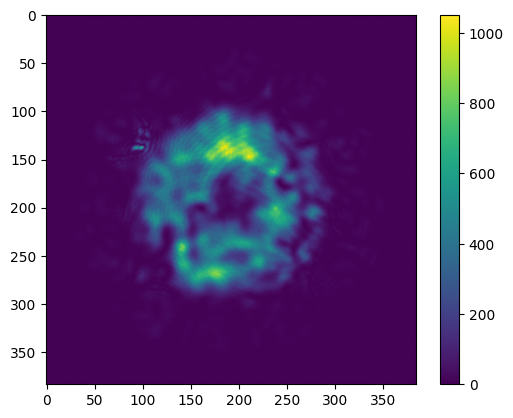

In [3]:
idx = 8
random: bool = True
if random:
    idx = np.random.randint(0, len(CP))

plt.imshow(CP[idx, ...], vmin=0)
plt.colorbar()

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

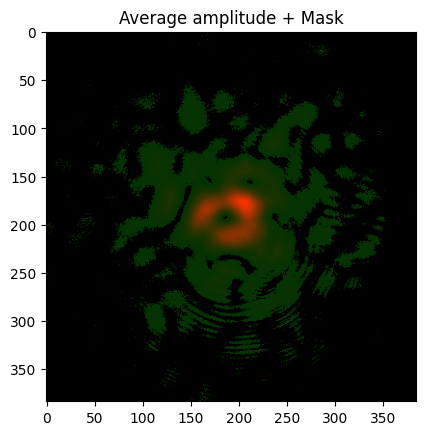

5.27142333984375


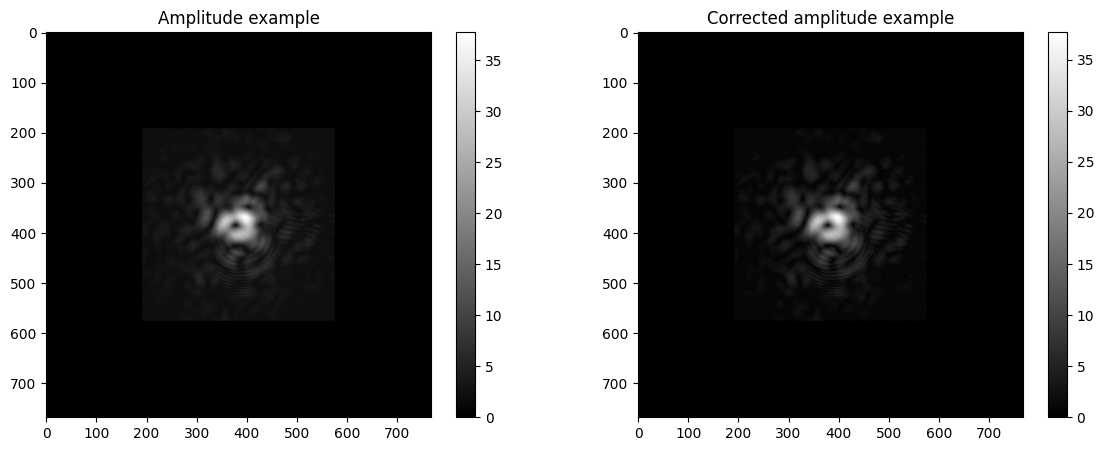

In [4]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.01, plot_result=True, plot_mask=True)
print(noise_corr)

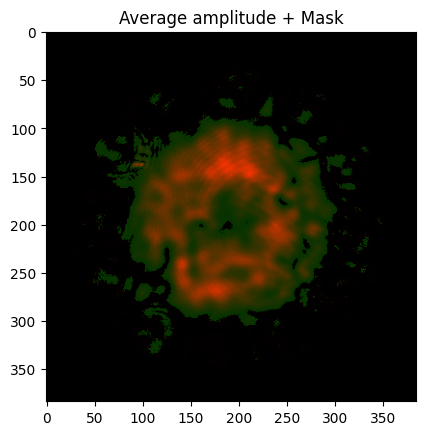

5.228841145833333


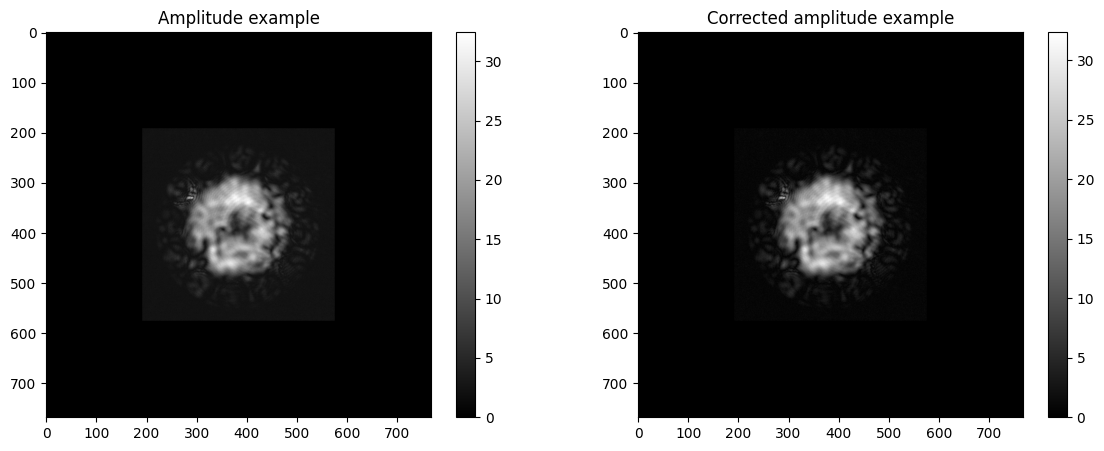

In [5]:
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0,), mask_trsh=0.02, plot_mask=True, plot_result=True)
print(noise_corrCP)

Let's detect the average centroids

In [6]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(-1, -2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(-1, -2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (0.0, 191.69605320037775)
Average centroid CL: (0.0, 191.44121431842422)


### Data preparation

Select data for phase retrieval

294
(294, 294) 597247.5816203132
(294, 294) 219155.87883054017


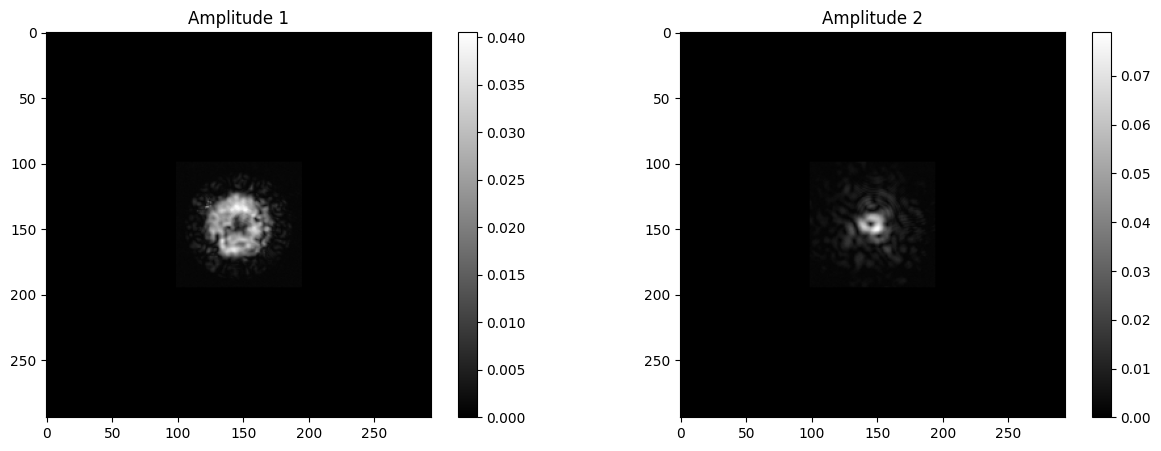

In [7]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

bin_cp = 4
bin_cl = 4
N_window = compute_N_win(561.4e-9, 100e-3, bin_cp * 3.45e-6, bin_cl * 3.45e-6)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - noise_corrCP)) #

# CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - noise_corr)) #
# CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
# ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
ft = np.flip(ft, axis=0)
# ft = np.flip(ft, axis=1)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

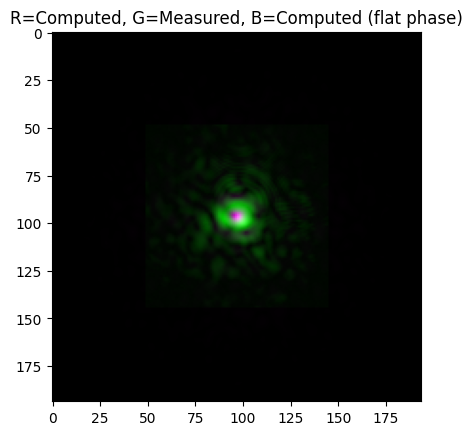

In [8]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = 50

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

Define the phase retrieval support

c:\Users\saucourt\venvs\ml\lib\site-packages\matplotlib\colors.py:2271: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


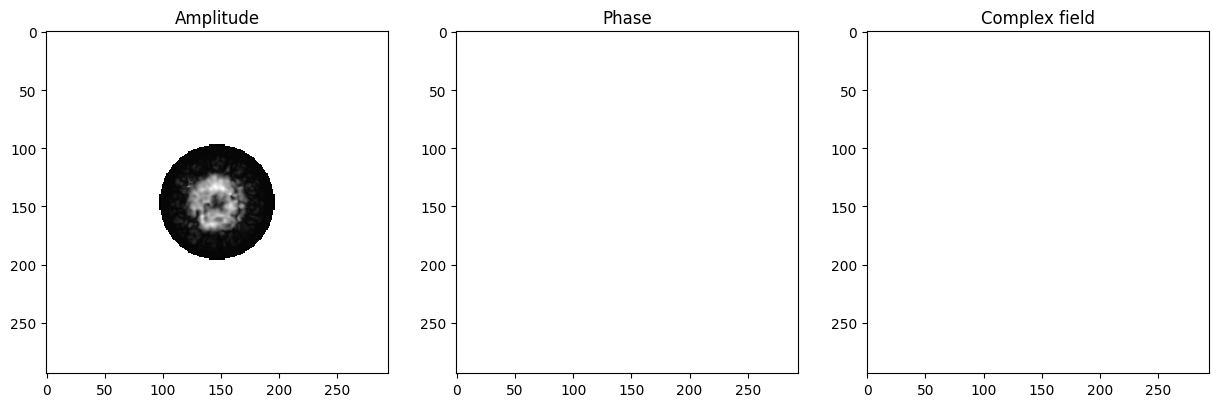

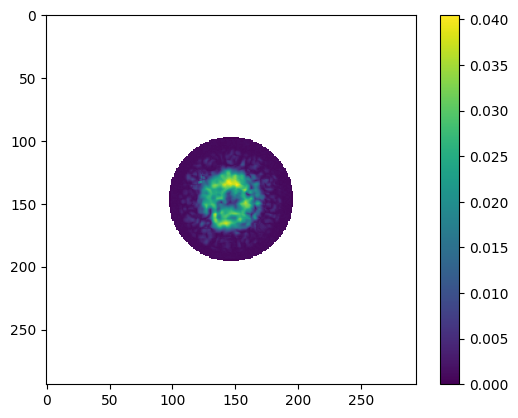

In [9]:
support = spr.supports.threshold_support(field, threshold=0.01)
support = spr.supports.disk_support(field, radius=50, offsets=(0,0))
supported_field = field.copy()
supported_field[np.logical_not(support)] = np.nan
_ = spr.plots.complex_imshow(supported_field)

plt.figure()
plt.imshow(supported_field)
plt.colorbar()

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

In [10]:
from matplotlib.colors import hsv_to_rgb

def complex_to_hsv(z, rmin, rmax, hue_start=0, power=1):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    amp = np.power(amp, power)
    ph = np.angle(z, deg=True) + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp - rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = np.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

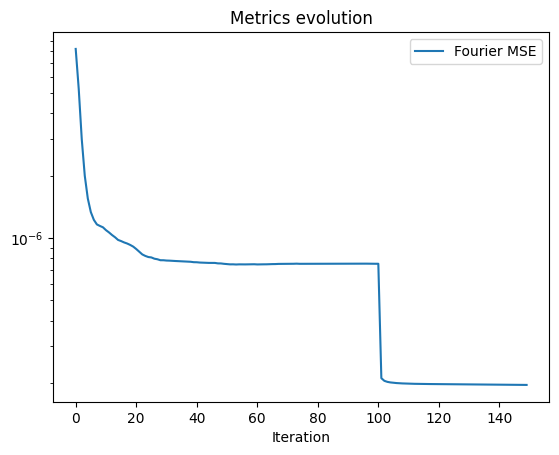

(-0.5, 173.5, 173.5, -0.5)

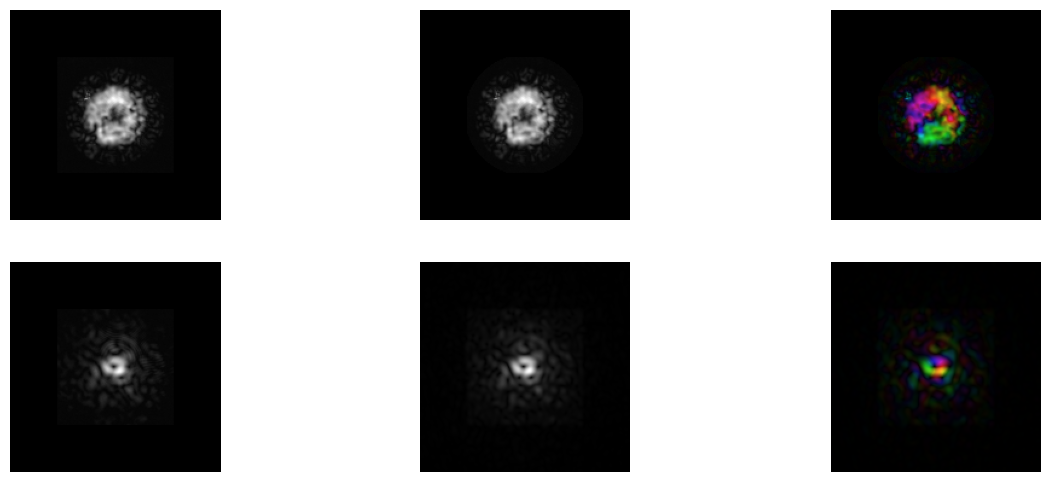

In [11]:
from speckleret.transforms import fourier_transform

results = []

# x, result = spr.retrievalmath.run(
#         magnitudes=(np.abs(field), np.abs(ft)),
#         support=support,
#         init=spr.initializers.flat_phases(magnitude=np.abs(field)),
#         algorithm=spr.retrievalmath.HIO,
#         algorithm_kwargs={'beta': 0.9},
#         max_iter=50,
#         rel_tol=1e-6,
# )
# results.append(result)

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=x,
        init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        algorithm=spr.retrievalmath.RAAR,
        algorithm_kwargs={'beta': 0.7},
        max_iter=100,
        rel_tol=1e-6,
)
results.append(result)

# # x = np.abs(field) * np.exp(1j * np.angle(x))

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        init=x,
        algorithm=spr.retrievalmath.ER,
        max_iter=50,
        rel_tol=1e-6,
)
results.append(result)



x_hat = x
# x_hat = np.abs(field) * np.exp(1j * np.angle(x))
# x_hat[np.logical_not(support)] = 0


spr.retrievalmath.report_convergence_results(merge_dicts(results))
plt.show()

y_hat = fourier_transform(x_hat)

win_crop = 60
# _ = spr.plots.complex_imshow(x_hat[win_crop:-win_crop, win_crop:-win_crop], remove_ticks=True, figsize=(12,4))
# plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(field[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(np.abs(x_hat[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(complex_to_hsv(x_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(x_hat))))
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(np.abs(ft[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(np.abs(y_hat[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(complex_to_hsv(y_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(y_hat))))
plt.axis('off')

0.9985090834768188


(-0.5, 93.5, 93.5, -0.5)

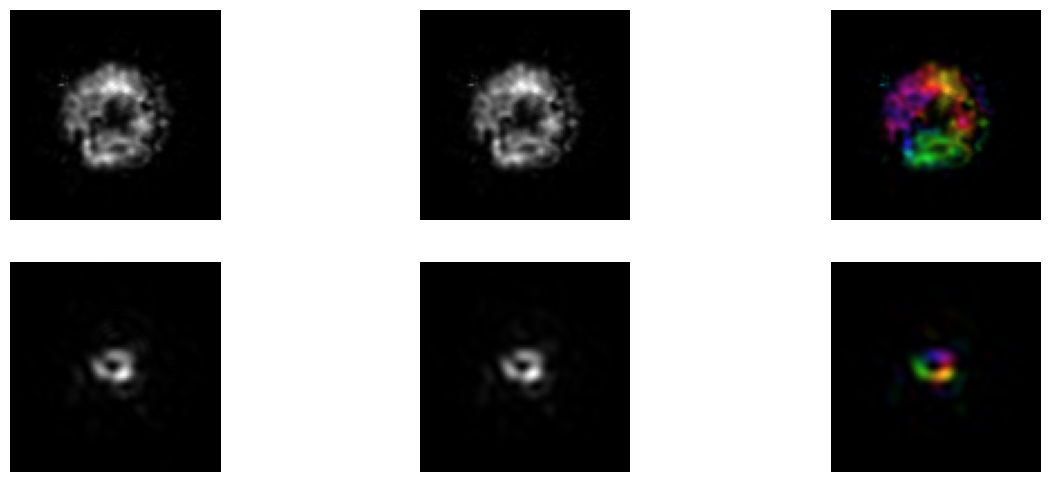

In [12]:
from waveoptics.metrics.numpy import pearson

win_crop = 100



print(pearson(
    x=np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])**2,
    y=np.abs(y_hat[win_crop:-win_crop, win_crop:-win_crop])**2,
))

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(field[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(np.abs(x_hat[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
xx =np.abs(x_hat)**2  * np.exp(1j * np.angle(x_hat))
# plt.imshow(complex_to_hsv(x_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(x_hat))))

plt.imshow(complex_to_hsv(xx[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(xx))))
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(np.abs(y_hat[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)

yy =np.abs(y_hat)**2  * np.exp(1j * np.angle(y_hat))
# plt.imshow(complex_to_hsv(y_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(y_hat))))
plt.imshow(complex_to_hsv(yy[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(yy))))
plt.axis('off')

In [13]:
import os
import cv2
from waveoptics.plots.plots import complex_to_hsv

def build_modal_base(path: str):
    files = [
        'LP01y_field', 'LP02y_field', 'LP03y_field',
        'LP11ay_field', 'LP12ay_field', 'LP21ay_field',
        'LP23ay_field', 'LP31ay_field',
        'LP32ay_field', 'LP41ay_field', 'LP42ay_field',
        'LP51ay_field', 'LP61ay_field',
    ]
    rotations = [
        0, 0, 0,
        90, 90, 90/2,
        90/2, 90/3,
        90/3, 90/4, 90/4,
        0, 90/6,
    ]

    modes = []
    for i in range(len(files)):
        print(files[i])
        lp_data = loadmat(os.path.join(path, files[i] + '.mat'))['data']
        lp_data = np.reshape(lp_data, [1000, 1000, 5])
        lp_mode = lp_data[..., 3]
        lp_mode[np.isnan(lp_mode)] = 0 + 0j
        lp_mode = lp_mode / np.sqrt(np.sum(np.square(np.abs(lp_mode))))
        modes.append(np.expand_dims(lp_mode, -1))
        if rotations[i] != 0:
            (h, w) = lp_mode.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, rotations[i], 1.0)
            rotated_mode = cv2.warpAffine(np.real(lp_mode), M, (w, h)) + 1j * cv2.warpAffine(np.imag(lp_mode), M, (w, h))
            modes.append(rotated_mode)

    return modes

modes = build_modal_base(path=r'C:\Users\saucourt\Downloads\T12 L8407 fields')

LP01y_field
LP02y_field
LP03y_field
LP11ay_field
LP12ay_field
LP21ay_field
LP23ay_field
LP31ay_field
LP32ay_field
LP41ay_field
LP42ay_field
LP51ay_field
LP61ay_field


0.9999999999999999


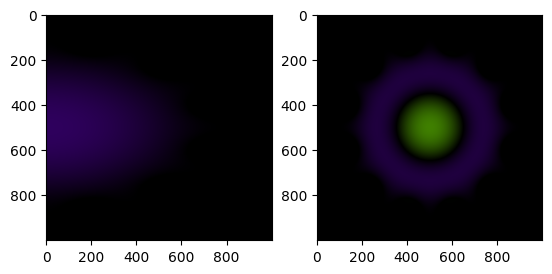

1.0


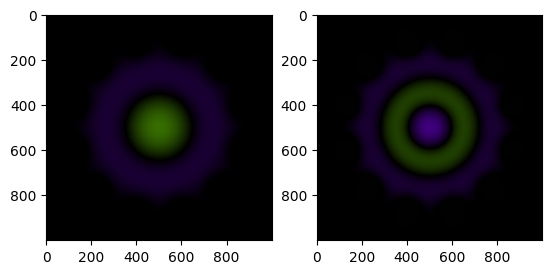

1.0000000000000002


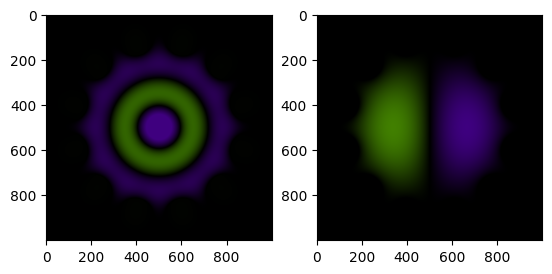

0.9999999999999999


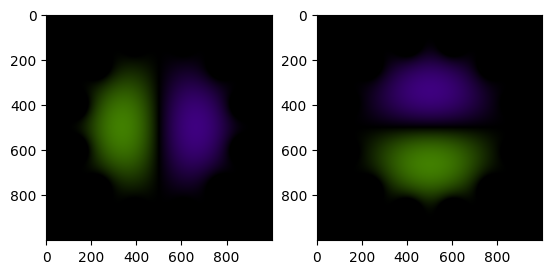

0.9999999999999989


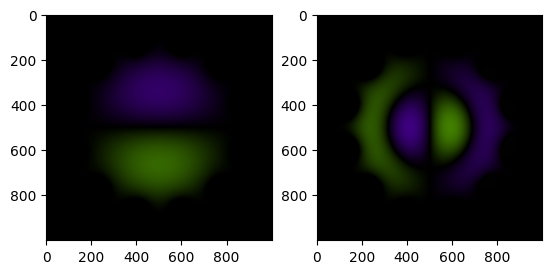

1.0000000000000007


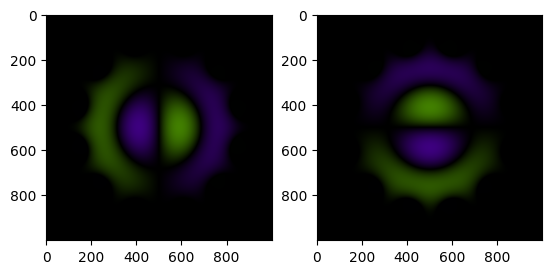

0.9999999999999861


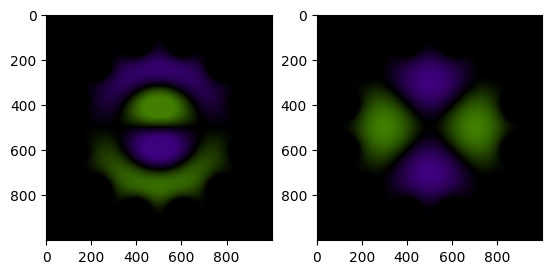

1.0


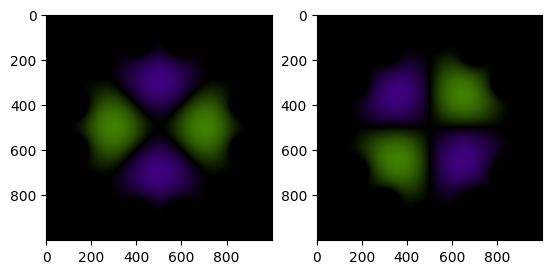

0.9999617689828006


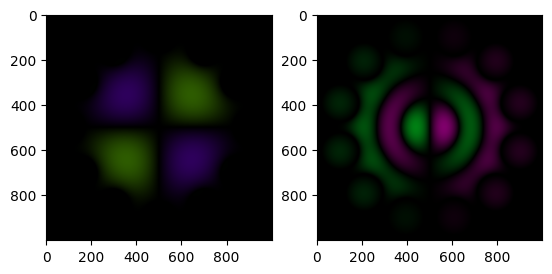

1.0


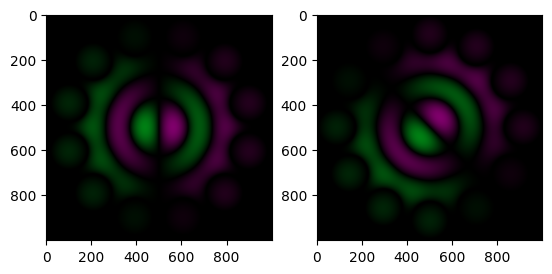

0.9998515678827351


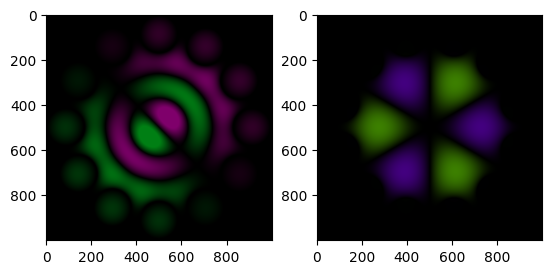

0.9999999999999999


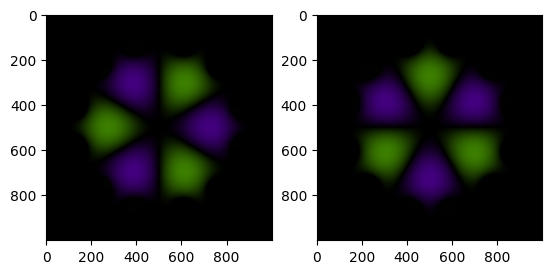

0.9999422110283616


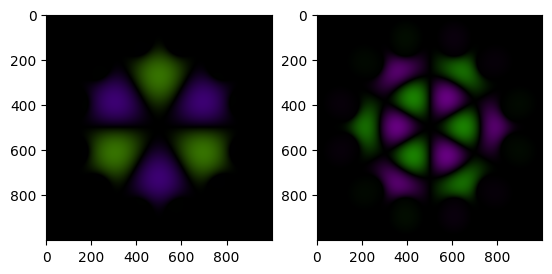

0.9999999999999996


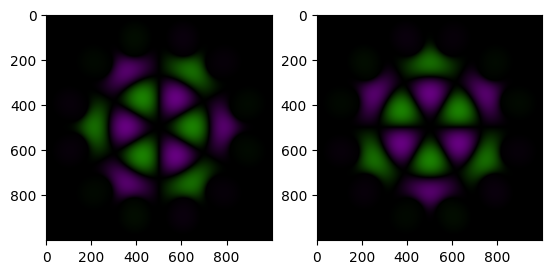

0.9998655987320384


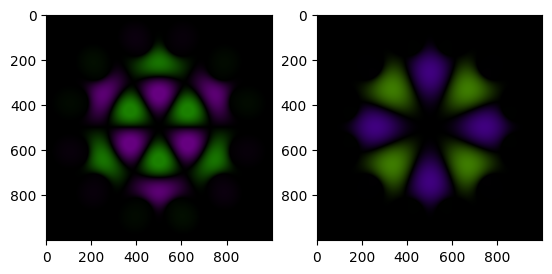

0.9999999999999989


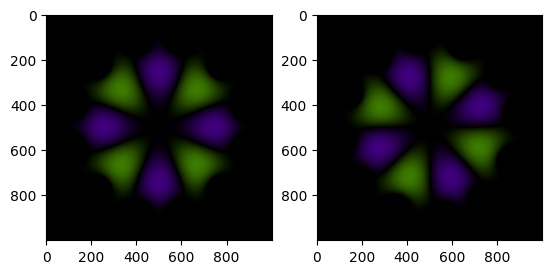

0.9999168863433959


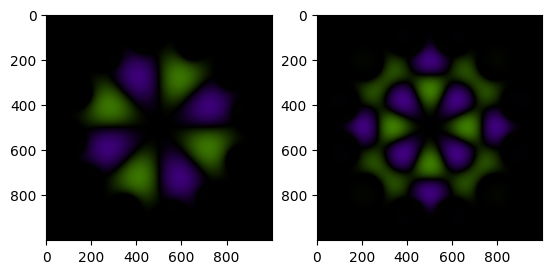

0.9999999999999997


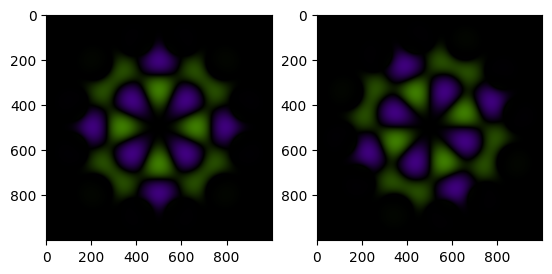

0.9998274841411527


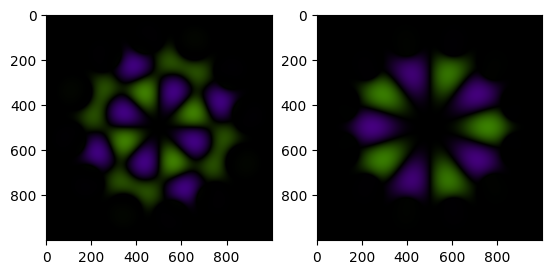

0.9999999999999998


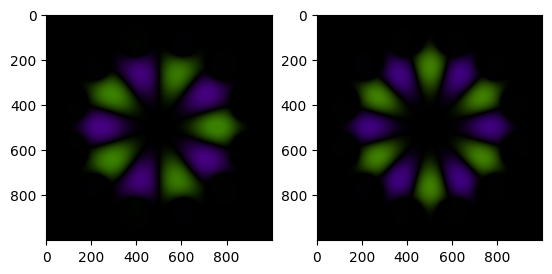

1.0000000000000002


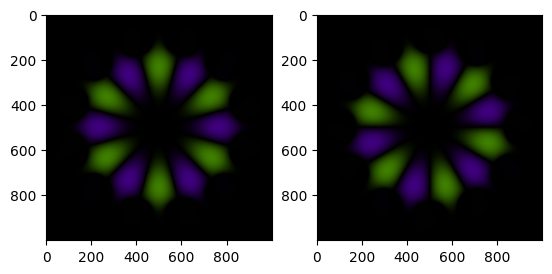

0.9998662592229842


IndexError: list index out of range

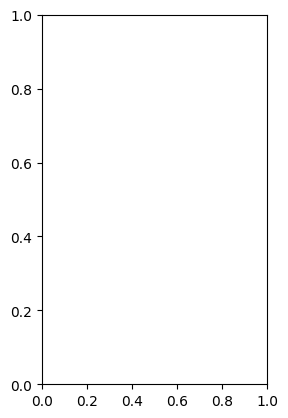

In [14]:

for i in range(len(modes)):
    # i = 0
    print(np.sum(np.square(np.abs(modes[i]))))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(complex_to_hsv(modes[i], rmin=0, rmax=np.max(np.abs(modes[i+1]))))
    plt.subplot(1, 2, 2)
    plt.imshow(complex_to_hsv(modes[i+1], rmin=0, rmax=np.max(np.abs(modes[i+1]))))

    plt.show()

In [ ]:
modess = np.concatenate(modes, axis=-1)
modess.shape

modess = modess.reshape(1000*1000, 13)
print(modess.shape)

scalar_products = modess.conj().T @ modess

(1000000, 13)


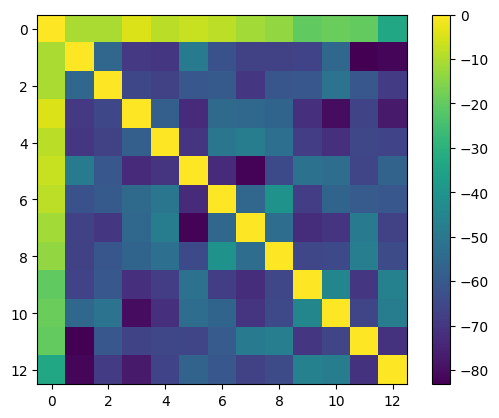

In [ ]:
plt.imshow(10*np.log10(np.abs(scalar_products)))
plt.colorbar()

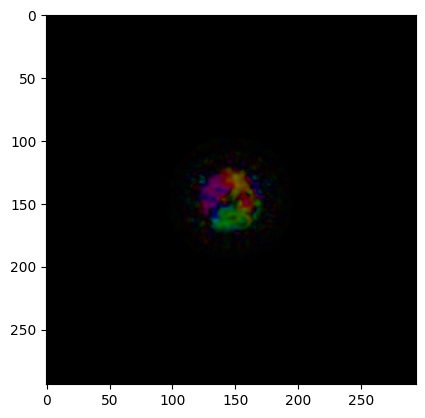

In [ ]:
plt.imshow(complex_to_hsv(x_hat, rmin=0, rmax=np.max(np.abs(x_hat))))

In [ ]:
99.6648 / 495 

0.2013430303030303

In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

# Simulation grid
sim_px_um = 99.6648e-6 / 495
x_sim = np.arange(0, 1000 * sim_px_um, sim_px_um)
X_sim, Y_sim = np.meshgrid(x_sim, x_sim)
Z = modes[1]

# Retrieval grid
ret_px_um = 0.1 * 3.45e-6
x_ret = np.arange(0, 294 * ret_px_um, ret_px_um)
X_ret, Y_ret = np.meshgrid(x_ret, x_ret)


# Interpolator
Z_real = RegularGridInterpolator((x_sim, x_sim), Z.real, bounds_error=False, fill_value=0)
Z_imag = RegularGridInterpolator((x_sim, x_sim), Z.imag, bounds_error=False, fill_value=0)

Zc = Z_real(points).reshape(Y_ret.shape) + 1j * Z_imag(points).reshape(Y_ret.shape)
# interp = RegularGridInterpolator((x_sim, x_sim), Z, bounds_error=False, fill_value=0)
# Zc = interp(np.stack([Y_ret.ravel(), X_ret.ravel()], axis=-1)).reshape(Y_ret.shape)


print(Zc.shape)


plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(complex_to_hsv(Z, rmin=0, rmax=np.max(np.abs(Z))))
plt.subplot(1, 2, 2)
plt.imshow(complex_to_hsv(Zc, rmin=0, rmax=np.max(np.abs(Zc))))

NameError: name 'points' is not defined

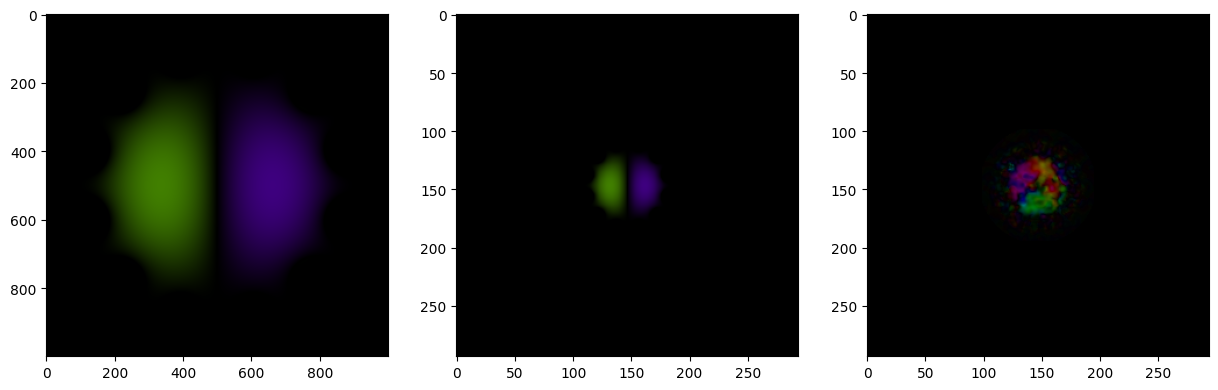

In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

# --- Simulation Grid ---
# sim_px_um = 99.6648e-6 / 495  # pixel size in meters
sim_px_um = 156.2e-6 / 495  # pixel size in meters
x_sim = np.arange(-500 * sim_px_um, 500 * sim_px_um, sim_px_um)
X_sim, Y_sim = np.meshgrid(x_sim, x_sim)

Z = modes[3]  # replace with your 2D array, real or complex

# --- Retrieval Grid (Coarser) ---
ret_px_um = 1 * 3.45e-6  # pixel size in meters
x_ret = np.arange(-294 / 2 * ret_px_um, 294 / 2 * ret_px_um, ret_px_um)
X_ret, Y_ret = np.meshgrid(x_ret, x_ret)

# --- Interpolation ---
points = np.stack([Y_ret.ravel(), X_ret.ravel()], axis=-1)  # note: [y, x] order

if np.iscomplexobj(Z):
    # Interpolate real and imaginary parts separately
    interp_real = RegularGridInterpolator((x_sim, x_sim), Z.real, bounds_error=False, fill_value=0)
    interp_imag = RegularGridInterpolator((x_sim, x_sim), Z.imag, bounds_error=False, fill_value=0)
    Zc = interp_real(points).reshape(Y_ret.shape) + 1j * interp_imag(points).reshape(Y_ret.shape)
else:
    interp = RegularGridInterpolator((x_sim, x_sim), Z, bounds_error=False, fill_value=0)
    Zc = interp(points).reshape(Y_ret.shape)

lp11 = Zc
lp11 = lp11 / np.sqrt(np.sum(np.square(np.abs(lp11))))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(complex_to_hsv(Z, rmin=0, rmax=np.max(np.abs(Z))))
plt.subplot(1, 3, 2)
plt.imshow(complex_to_hsv(Zc, rmin=0, rmax=np.max(np.abs(Zc))))
plt.subplot(1, 3, 3)
plt.imshow(complex_to_hsv(x_hat, rmin=0, rmax=np.max(np.abs(x_hat))))
# plt.imshow(np.abs(Zc))

In [ ]:
(h, w) = lp11.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, 90, 1.0)
lp11r = cv2.warpAffine(np.real(lp11), M, (w, h)) + 1j * cv2.warpAffine(np.imag(lp11), M, (w, h))

In [ ]:
vortex = x_hat / np.sqrt(np.sum(np.square(np.abs(x_hat))))
vv = lp11 + 1j * lp11r
vv = vv / np.sqrt(np.sum(np.square(np.abs(vv))))

In [ ]:
np.sum(np.square(np.abs(vv )))

0.9999999999999999

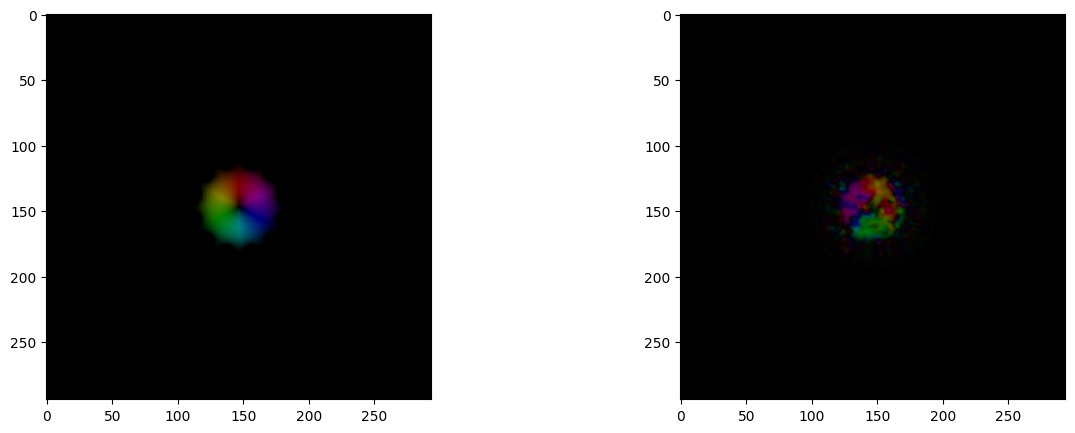

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(complex_to_hsv(vv, rmin=0, rmax=np.max(np.abs(vv))))
plt.subplot(1, 2, 2)
plt.imshow(complex_to_hsv(vortex, rmin=0, rmax=np.max(np.abs(vortex))))

In [ ]:
def zoom_image(img, zoom_factor):
    h, w = img.shape
    center_x, center_y = w // 2, h // 2

    # Resize the image
    resized = cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    new_h, new_w = resized.shape
    start_x = new_w // 2 - w // 2
    start_y = new_h // 2 - h // 2

    if zoom_factor >= 1.0:
        cropped = resized[start_y:start_y + h, start_x:start_x + w]
    else:
        cropped = np.zeros_like(img)
        insert_x = w // 2 - new_w // 2
        insert_y = h // 2 - new_h // 2
        cropped[insert_y:insert_y + new_h, insert_x:insert_x + new_w] = resized

    return cropped

def zoom_complex_image(cplx, zoom_factor):
    Z_real = zoom_image(cplx.real, zoom_factor)
    Z_imag = zoom_image(cplx.imag, zoom_factor)
    return Z_real + 1j * Z_imag

def rotate_image(img, degrees):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, degrees, 1.0)
    img = cv2.warpAffine(np.real(img), M, (w, h))
    return img

def rotate_complex_image(cplx, degrees):
    Z_real = rotate_image(cplx.real, degrees)
    Z_imag = rotate_image(cplx.imag, degrees)
    return Z_real + 1j * Z_imag

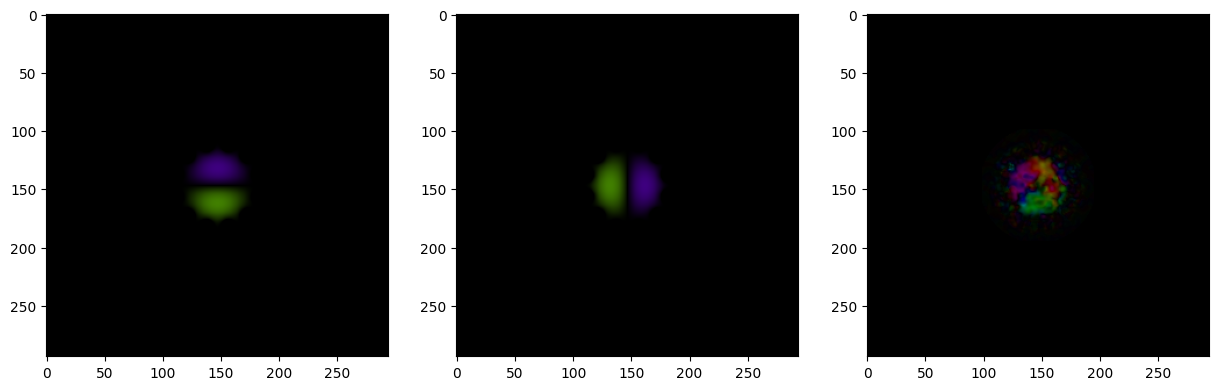

In [ ]:
vvr = zoom_complex_image(vv, zoom_factor=2)
vvr = rotate_complex_image(vvr, degrees=-180)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(complex_to_hsv(vv, rmin=0, rmax=np.max(np.abs(vv))))
plt.subplot(1, 3, 2)
plt.imshow(complex_to_hsv(lp11, rmin=0, rmax=np.max(np.abs(vvr))))
plt.subplot(1, 3, 3)
plt.imshow(complex_to_hsv(vortex, rmin=0, rmax=np.max(np.abs(vortex))))

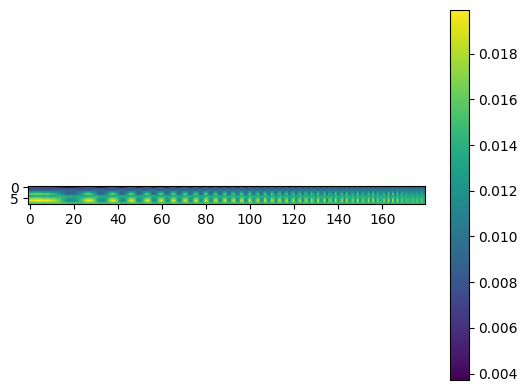

In [ ]:
def power_overlap_integral(field, mode):
    return np.square(np.abs(np.sum(field * np.conj(mode)))) / (np.sum(np.square(np.abs(field))) * np.sum(np.square(np.abs(mode))))
    

rots = np.arange(0, 180, 1)
zooms = np.arange(0.8, 1.2, 0.05)

sp2 = np.nan * np.zeros(shape=(len(zooms), len(rots)))
# vv = lp11

for z in range(len(zooms)):
    vvr = zoom_complex_image(vv, zoom_factor=zooms[z])
    vvr = vvr / np.sqrt(np.sum(np.square(np.abs(vvr))))
    
    for i in range(len(rots)):
        vvr = rotate_complex_image(vvr, degrees=rots[i])
        vvr = vvr / np.sqrt(np.sum(np.square(np.abs(vvr))))
        sp2[z, i] = power_overlap_integral(vortex, vvr)

plt.imshow(sp2)
plt.colorbar()

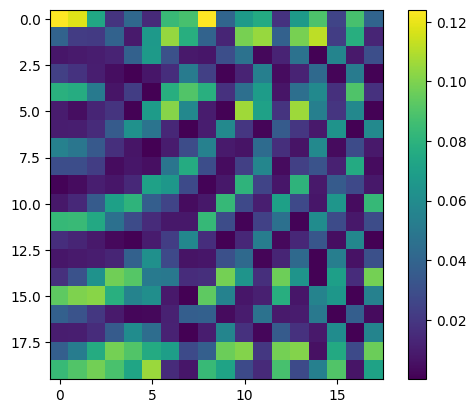

In [ ]:
rots = np.arange(0, 180, 10)
shift = np.arange(-20, 20, 2)

sp2 = np.nan * np.zeros(shape=(len(shift), len(rots)))
# vv = lp11r

vvr = zoom_complex_image(vv, zoom_factor=zooms[z])
vvr = vvr / np.sqrt(np.sum(np.square(np.abs(vvr))))

vvr = np.roll(vvr, shift=-10, axis=1)

for s in range(len(shift)):
    vvr = np.roll(vvr, shift=shift[s], axis=0)
    
    for i in range(len(rots)):
        vvr = rotate_complex_image(vvr, degrees=rots[i])
        vvr = vvr / np.sqrt(np.sum(np.square(np.abs(vvr))))
        sp2[s, i] = power_overlap_integral(vortex, vvr)

plt.imshow(sp2)
plt.colorbar()

In [ ]:
ret_px_um / sim_px_um

68.53974522599755

In [ ]:
x_ret.shape

(294,)

In [ ]:
x_hat.shape

(294, 294)

In [ ]:
x.shape

(1000,)

In [ ]:
sim_px_um = 99.6648e-6 / 495
x = np.arange(0, 1000 * sim_px_um, sim_px_um )

In [ ]:
sim_px_um

2.013430303030303e-07

In [ ]:
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

# Original grid
x = np.linspace(0, 5, 6)       # 6 points
y = np.linspace(0, 5, 6)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)      # 2D function

# Create interpolator
f_interp = interp2d(x, y, Z, kind='linear')

# New finer grid
x_new = np.linspace(0, 5, 50)
y_new = np.linspace(0, 5, 50)
Z_new = f_interp(x_new, y_new)

# Plot
plt.imshow(Z_new, extent=(0,5,0,5), origin='lower')
plt.title("Interpolated Image")
plt.colorbar()
plt.show()

(294, 294) (495, 495)


(-0.5, 94.5, 94.5, -0.5)

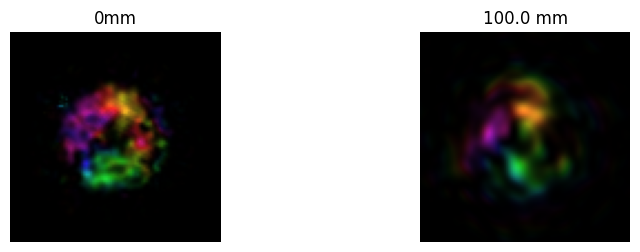

In [ ]:
from waveoptics.propag.numpy import frt_2d, frt_2d_propagator

dz = 100e-3
xx = np.pad(x_hat, pad_width=(100, 101))
print(x_hat.shape, xx.shape)
prop = frt_2d_propagator(xx, dz=dz, wavelength=561.4e-9, pixel_size=4*3.45e-6)
yy = frt_2d(xx, prop, dz=dz, wavelength=561.4e-9, pixel_size=4*3.45e-6)


win_crop = 200

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
plt.title(f"0mm")
xxx =np.abs(xx)**2  * np.exp(1j * np.angle(xx))
plt.imshow(complex_to_hsv(xxx[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(xxx))))
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title(f"{dz * 1000} mm")
yyy =np.abs(yy)**2  * np.exp(1j * np.angle(yy))
plt.imshow(complex_to_hsv(yyy[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(yyy))))
plt.axis('off')

# plt.imshow(complex_to_hsv(xx[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(xx))))



ValueError: zero-size array to reduction operation minimum which has no identity

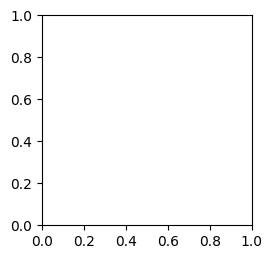

In [ ]:
win_crop = 500

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
xxx =np.abs(xx)**2  * np.exp(1j * np.angle(xx))
plt.imshow(complex_to_hsv(xxx[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(xxx))))
plt.axis('off')

plt.subplot(2, 3, 2)
yyy =np.abs(yy)**2  * np.exp(1j * np.angle(yy))
plt.imshow(complex_to_hsv(yyy[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(yyy))))
plt.axis('off')

In [ ]:
np.savez(file='./PR_result.npz', field=field, fourier=ft, retrieved_field=x_hat, retrieved_fourier=y_hat)


In [ ]:
pr = np.load('./PR_result.npz')
print(pr.keys())
print(pr['retrieved_field'].shape)

KeysView(NpzFile './PR_result.npz' with keys: field, fourier, retrieved_field, retrieved_fourier)
(294, 294)
